[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is similar to [linear regression](/blog/ml-linear-regression/), but instead of predicting a continuous output, classifies training examples by a set of categories or labels.  For example, linear regression on a set of social and economic data might be used to predict a person's income, but logistic regression could be used to predict whether that person was married, had children, or had ever been arrested.  In a basic sense, logistic regression only answers questions that have yes / no answers, or questions that can be answered with a 1 or 0.  However, it can easily be [extended](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) to problems where there are a larger set of categories.

Here, I'm using the [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) dataset from UCI. It maps thirteen continuous variables representing chemical contents of a wine to three labels, each a different winery in Italy.

# Loading and Plotting Data
 
Initially, I'm only using two features from the data set: alcohol and ash.  The labels are supplied as an array of data with values from `1` to `3`, but at first, I only want a simple regression problem with a yes or no answer.  

To do this, I first filter the data set, reducing it to only include wines with labels `1` or `2`.  Then, I use the scikit-learn `label_binarize` function, which takes an $m$-length list with $n$ possible values (two, in this case), and converts it to an $m \times n$ matrix, where each column represents one label with a value of `1`, and all others with a value of `0`.  I choose the first column, though the second would be equally valid here, just with the labels reversed.

I've provided a small example of `label_binarize` below, shuffling the whole input data set first (the examples are sorted by winery), and then selecting the first ten.

Con un conjunto de datos de vinos para un problema de "sí o no". Se seleccionan solo dos características y se filtran los vinos a tipos 1 o 2. Luego, se usa una función para convertir esos tipos en un formato binario (1 o 0), preparando los datos para un modelo de respuesta simple.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')

reduced = data[data['class'] <= 2]
#X = reduced.as_matrix(columns=['alcohol', 'ash'])
X = reduced[['alcohol', 'ash']].values
y = label_binarize(reduced['class'].values, classes=[1, 2])[:,0]

example = np.copy(data['class'].values)
np.random.shuffle(example)
example = example[0:10]
print('original:', example)
example = label_binarize(example, classes=list(set(example)))
print('binarized:', example)
print('1s vs all:', example[:,0])

original: [3 1 2 2 3 1 2 1 1 1]
binarized: [[0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
1s vs all: [0 1 0 0 0 1 0 1 1 1]


I also split the data into training and testing sets before going further.  A simple way to do this is with the `train_test_split` function from scikit-learn, which allows me to specify a percentage (here 25%) to sample randomly from the data set and partition away for testing.

Antes de seguir, dividí los datos en dos grupos: uno para "entrenar" el modelo y otro para "probarlo". Usé una herramienta llamada train_test_split que toma el 25% de los datos al azar para probar, y el resto para entrenar. Así me aseguro de que el modelo funcione bien con datos nuevos.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('train:', len(X_train), 'test:', len(X_test))

train: 97 test: 33


Because I'm going to be drawing a lot of data plots, I define a function that takes an $n \times 2$ array of data points `xy`, and an $n \times 1$ array `labels` to vary the symbol and color for each point.  This function supports three distinct labels, sufficient for this data set.

Se define una función para dibujar muchos gráficos de datos, que toma puntos xy y etiquetas labels para cambiar el símbolo y color de cada punto, soportando hasta tres tipos de etiquetas.

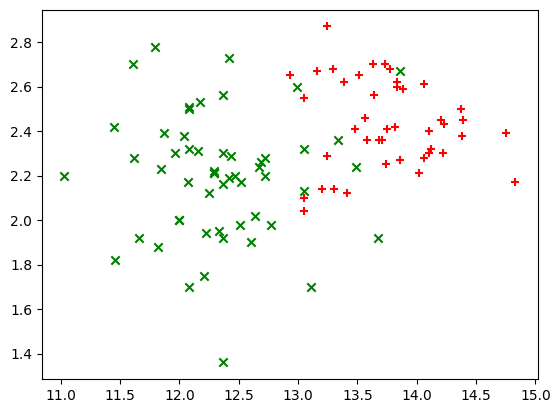

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train)

There's a fairly obvious area near the center of the plot where a line could divide the two colors of points with a small amount of error.

# Simple Logistic Regression

To implement logistic regression, I need a hypothesis function $h_\theta(x)$, a cost function $J(\theta)$, and a gradient function that computes the partial derivatives of $J(\theta)$.

In logistic regression, $h_\theta$ is the [sigmoid](https://www.quora.com/Logistic-Regression-Why-sigmoid-function) function.  The sigmoid function is bounded between 0 and 1, and produces a value that can be interpreted as a probability.  This value can also be a yes / no answer with a cross-over, or decision boundary, at 0.5:

$$
h_\theta(x) = \frac{1}{1 + e^{ \theta^Tx}}
$$

Using [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) from linear regression isn't a good idea here, as the resulting cost function [isn't convex](http://mathworld.wolfram.com/SigmoidFunction.html) and so is not well-suited for gradient descent.  Instead, the difference of $h_\theta(x^i) - y^i$ is calculated differently for $y=0$ and $y=1$, and the result is [transformed](https://stackoverflow.com/questions/32986123/why-the-cost-function-of-logistic-regression-has-a-logarithmic-expression) [logarithmically](https://math.stackexchange.com/questions/886555/deriving-cost-function-using-mle-why-use-log-function) into a convex function: 

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))
$$

Fortunately, the [derivative](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression) of this function is exactly the same as that of linear regression, just with a different $h_\theta(x)$:

$$
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i
$$

In [4]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(pos - neg) / (len(X))

def gradient(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    error = sigmoid(X.dot(theta)) - y
    return X.T.dot(error) / len(X)

It's worth noting the treatment of `y` and `theta` above.  In each function, I explicitly convert each to an $n$ or $m \times 1$ `ndarray`, so the matrix operations work correctly.  An alternative is to use a numpy `matrix`, which has stricter linear algebra semantics and treats 1-dimensional matrices more like column vectors.  However, I found that it was awkward to get the matrix interface to work correctly with both the optimization function used below, and with TensorFlow.  The indexing syntax can be thought of as explicitly columnizing the array of parameters or labels.

Instead of manually writing a gradient descent, I use an optimization algorithm from Scipy called [`fmin_tnc`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) to perform it.  This function takes as parameters the cost function, an initial set of parameters for $\theta$, the gradient function, and a tuple of args to pass to each.  I define a `train` function that prepends a columns of 1s to the training data (allowing for a bias parameter $\theta_0$), run the minimization function and return the first of its return values, final parameters for $\theta$.

Para que las operaciones matemáticas funcionen bien, me aseguro de que mis datos (y) y los parámetros del modelo (theta) tengan la forma correcta. En lugar de calcular los ajustes del modelo a mano, uso una herramienta de Scipy llamada fmin_tnc. Esta herramienta encuentra los mejores parámetros para el modelo, y yo la uso dentro de una función train que prepara los datos añadiendo una columna extra de unos para el "sesgo" del modelo.

In [5]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [64.84144557 -4.42423201 -2.90291446]


  NIT   NF   F                       GTG
    0    1  6.931471805599453E-01   1.60251929E-01
    1    3  6.913083031172278E-01   7.21394387E-04
tnc: fscale = 37.2318
    2    5  6.878512864330827E-01   2.99191033E-01
tnc: fscale = 1.82821
    3    7  6.844259154379941E-01   7.01598154E-04
tnc: fscale = 37.7534
    4    9  6.797479323259084E-01   4.03185358E-01
tnc: fscale = 1.57488
    5   11  6.751324208835455E-01   6.78631935E-04
tnc: fscale = 38.3869
    6   13  6.726530717034879E-01   2.15062524E-01
tnc: stepmx = 1000
    7   15  4.786665206639982E-01   6.37898933E-02
    8   19  3.048189853819517E-01   1.11135201E-01
    9   23  2.889431445214590E-01   1.27941099E-02
   10   25  2.883952282481207E-01   9.10951686E-04
   11   27  2.875052879729750E-01   1.28015857E-02
   12   29  2.774061973438661E-01   1.66808969E-01
   13   31  2.074011201236618E-01   1.22465512E-02
   14   33  2.071190367847019E-01   7.47844538E-04
   15   35  2.057675419685919E-01   2.89948152E-07
tnc: fscale = 

# Decision Boundaries and Evaluation


I can evaluate the results of the optimization visually and statistically, but I also need one more function: `predict`, which takes an array of examples `X` and learned parameter values `theta` as inputs and returns the predicted label for each.  Here too, 1s must be prepended to the inputs, and I return an integer value representing whether the result of the `sigmoid` hypothesis function is equal to or greater than 0.5.

To test the results of those predictions, Scikit-learn provides three functions to calculate [accuracy, precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).  The test data from earlier is used here, so the results represent the performance of the classifier on unseen data.

Primero se crea una función predict que, usando los parámetros aprendidos (theta), recibe nuevos ejemplos y devuelve la clase predicha (0 o 1), aplicando la función sigmoide y usando 0.5 como corte. Luego, para saber qué tan bien funciona el modelo, se usan funciones de Scikit‑learn que calculan exactitud, precisión y recall sobre los datos de prueba, es decir, sobre ejemplos que el modelo no había visto antes.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return (sigmoid(X * np.matrix(theta).T) >= 0.5).astype(int)

predictions = predict(X_test, theta)
predictions = np.asarray(predictions).flatten()
print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.9393939393939394
precision: 0.9473684210526316
recall: 0.9375


It's much more interesting to review the results visually, at least while the number of features is limited to two.  To do this, I need to plot the input points again, then overlay the decision boundary on top.  I tried several approaches for this in Matplotlib, and found that an unfilled countour plot gave me the best results.  This can also be done by manually calculating the function to plot, or using a filled contour plot that shades over the actual areas, but doing the math by hand is tedious, and the colormaps for filled contour plots leave a lot to be desired visually.

Below, I define a function `plot_boundary` that takes $n \times 2$ matrix of feature values $(x_0, x_1)$ and a prediction function, then builds a mesh grid of $(x, y)$ points corresponding to possible $(x_0, x_1)$ values within the input range.  After running the prediction function on all of them, the result is an $(x, y, z)$ point in space.  Because the result isn't continuous and flips directly from 0 to 1, there's only one contour that can be drawn on the plot: the decision boundary.

Como solo hay dos características, es útil ver gráficamente cómo decide el modelo. Para eso se vuelven a dibujar los puntos de datos y se añade encima la “frontera de decisión” usando un gráfico de contornos sin relleno en Matplotlib. La función plot_boundary crea una rejilla de puntos posibles en el plano (x₀, x₁), aplica la función de predicción a cada uno y, como el resultado solo puede ser 0 o 1, el único contorno que aparece es justamente la línea que separa ambas clases: la frontera de decisión.

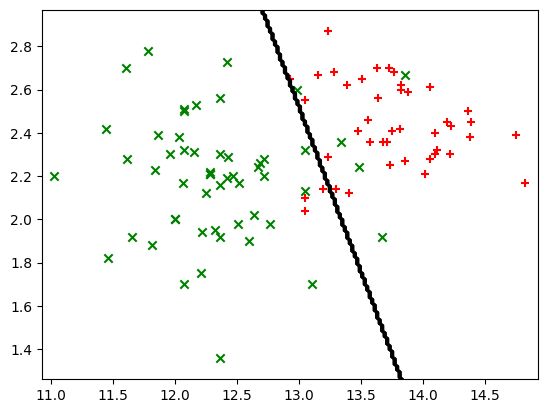

In [7]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')
        
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, theta))